# Movies recommendations with Azure Open AI & Azure Cognitive Search
## Part 3 - Recommandations

<img src="https://github.com/retkowsky/images/blob/master/movies_search.png?raw=true">

In [1]:
# %pip install azure-search-documents --pre --upgrade

In [2]:
# %pip install youtube-search-python

In [3]:
import json
import movieposters as mp
import openai
import os
import pytz
import requests
import sys
import time

from azure.core.credentials import AzureKeyCredential
from azure.search.documents import SearchClient
from azure.search.documents.indexes import SearchIndexClient
from azure.search.documents.models import Vector

from datetime import datetime
from dotenv import load_dotenv
from IPython.display import IFrame, display
from io import BytesIO
from PIL import Image
from youtubesearchpython import VideosSearch, Comments

In [4]:
sys.version

'3.10.10 (main, Mar 21 2023, 18:45:11) [GCC 11.2.0]'

In [5]:
local_tz = pytz.timezone(requests.get("https://ipinfo.io").json()["timezone"])
print("Local time:", datetime.now(local_tz).strftime("%d-%b-%Y %H:%M:%S"))

Local time: 05-Sep-2023 13:49:50


In [6]:
print("Open AI version:", openai.__version__)

Open AI version: 0.27.9


In [7]:
load_dotenv("azure.env")

openai.api_type: str = "azure"
openai.api_key = os.getenv("OPENAI_API_KEY")
openai.api_base = os.getenv("OPENAI_API_BASE")
openai.api_version = os.getenv("OPENAI_API_VERSION")

acs_endpoint = os.getenv("AZURE_SEARCH_SERVICE_ENDPOINT")
acs_key = os.getenv("AZURE_SEARCH_ADMIN_KEY")

In [8]:
# Azure Open AI embeddings model to use
embeddings_engine = "text-embedding-ada-002"

- Vector search is in public preview
- Model name: text-embedding-ada-002
- Model version: 2
- API version: 2023-05-15

In [9]:
# Azure Cognitive Search index name to create
index_name = "moviereview"

## 1. Functions

In [10]:
def acs_delete_index(index_name):
    """
    Deleting an Azure Cognitive Search index
    Input: index name (string)
    """
    start = time.time()
    search_client = SearchIndexClient(
        endpoint=acs_endpoint, credential=AzureKeyCredential(acs_key)
    )

    try:
        print("Deleting the Azure Cognitive Search index:", index_name)
        search_client.delete_index(index_name)
        print("Done. Elapsed time:", round(time.time() - start, 2), "secs")
    except:
        print("Cannot delete index. Check the index name.")

In [11]:
def acs_index_stats(index_name):
    """
    Get statistics about Azure Cognitive Search index
    Input: index name (string)
    """
    url = (
        acs_endpoint
        + "/indexes/"
        + index_name
        + "/stats?api-version=2021-04-30-Preview"
    )
    headers = {
        "Content-Type": "application/json",
        "api-key": acs_key,
    }
    response = requests.get(url, headers=headers)
    print("Azure Cognitive Search index status for:", index_name, "\n")

    if response.status_code == 200:
        res = response.json()
        print(json.dumps(res, indent=2))
        document_count = res["documentCount"]
        storage_size = res["storageSize"]

    else:
        print("Request failed with status code:", response.status_code)

    return document_count, storage_size

In [12]:
def acs_index_status(index_name):
    """
    Azure Cognitive Search index status
    Input: index name (string)
    """
    print("Azure Cognitive Search Index:", index_name, "\n")

    headers = {"Content-Type": "application/json", "api-key": acs_key}
    params = {"api-version": "2021-04-30-Preview"}
    index_status = requests.get(
        acs_endpoint + "/indexes/" + index_name, headers=headers, params=params
    )

    try:
        print(json.dumps((index_status.json()), indent=5))
    except:
        print("Request failed with status code:", response.status_code)

In [13]:
def azure_openai_text_embeddings(text):
    """
    Generating embeddings from text using Azure Open AI
    Input: text
    Output: vector embedding
    """
    embeddings = openai.Embedding.create(
        input=text,
        deployment_id=embeddings_engine,
    )
    embeddings = embeddings["data"][0]["embedding"]

    return embeddings

In [14]:
def get_list(movielist):
    """
    Get list of movies
    Input: movies list (list)
    Output: results (text)
    """
    pattern = r"\d+\.\s(.+)"
    matches = re.findall(pattern, movielist)
    for idx, movie in enumerate(matches, start=1):
        print(f"Movie {idx}: {movie}.")

    return matches

## 2. Azure Cognitive Search index

### Azure Cognitive Search vector store
<img src="https://github.com/retkowsky/images/blob/master/vector_search_architecture.png?raw=true">

In [15]:
acs_index_status(index_name)

Azure Cognitive Search Index: moviereview 

{
     "@odata.context": "https://azurecogsearcheastussr.search.windows.net/$metadata#indexes/$entity",
     "@odata.etag": "\"0x8DBAE03DD8B3409\"",
     "name": "moviereview",
     "defaultScoringProfile": null,
     "fields": [
          {
               "name": "imdb_id",
               "type": "Edm.String",
               "searchable": false,
               "filterable": true,
               "retrievable": true,
               "sortable": true,
               "facetable": true,
               "key": true,
               "indexAnalyzer": null,
               "searchAnalyzer": null,
               "analyzer": null,
               "normalizer": null,
               "synonymMaps": []
          },
          {
               "name": "title",
               "type": "Edm.String",
               "searchable": true,
               "filterable": true,
               "retrievable": true,
               "sortable": false,
               "facetable": f

In [16]:
document_count, storage_size = acs_index_stats(index_name)

Azure Cognitive Search index status for: moviereview 

{
  "@odata.context": "https://azurecogsearcheastussr.search.windows.net/$metadata#Microsoft.Azure.Search.V2021_04_30_Preview.IndexStatistics",
  "documentCount": 10784,
  "storageSize": 564411366
}


In [17]:
print("Number of documents in the index =", f"{document_count:,}")
print("Size of the index =", round(storage_size / (1024 * 1024), 2), "MB")

Number of documents in the index = 10,784
Size of the index = 538.26 MB


## 3. Functions

In [18]:
def azure_chatgpt_movies(prompt, max_retries=3, retry_delay=1):
    """
    Chat GPT with Azure Open AI
    Input: prompt (text)
    Output: results (string)
    """
    for _ in range(max_retries):
        try:
            response = openai.ChatCompletion.create(
                engine="gpt-35-turbo",  # Should be deployed in the AOAI studio
                messages=[
                    {
                        "role": "system",
                        "content": "You are an AI assistant that helps people to find \
                        information about movies.",
                    },
                    {"role": "user", "content": prompt},
                ],
                temperature=0.9,
                max_tokens=800,
                top_p=1,
                frequency_penalty=0,
                presence_penalty=0,
                stop=None,
            )

            resp = response["choices"][0]["message"]["content"]

            print("\033[1;31;34mPrompt:", prompt)
            print("\n\033[1;31;32mResponse:", resp)
            print("\033[1;31;35m")
            print("Powered by Azure AI")
            # Local time
            local_tz = pytz.timezone(
                requests.get("https://ipinfo.io").json()["timezone"]
            )
            print(datetime.now(local_tz).strftime("%d-%b-%Y %H:%M:%S"))

            return resp

        except Exception as e:
            print("Error:", str(e))
            print("Retrying...")
            time.sleep(retry_delay)

    print("Maximum retries exceeded. Unable to get a response.")

    return None

In [19]:
def get_movie_poster(imdb_id):
    """
    Display movie poster from its IMDB id
    Input: imdb id (string)
    Output: display image file and save as an image file
    """
    poster = mp.get_poster(id=imdb_id)
    response = requests.get(poster)

    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))
        display(img)
        # Save as a local file
        os.makedirs("movieposter", exist_ok=True)
        posterfile = os.path.join("movieposter", "movie_" + str(imdb_id) + ".jpg")
        img.save(posterfile)
    else:
        print("Failed to fetch the movie image.")

In [20]:
def get_trailer(movietitle):
    """
    Get youtube video trailer
    Input: movie title (string)
    Output: Display the trailer video
    """
    # Search video on youtube
    videosSearch = VideosSearch(movietitle, limit=1)
    video_results = videosSearch.result().get("result")

    if video_results:
        print("\033[1;31;34m")
        video_id = video_results[0].get("id")
        video_url = f"https://www.youtube.com/watch?v={video_id}"
        print("\033[1;31;34m", video_url)
        vid = IFrame(
            src=f"https://www.youtube.com/embed/{video_id}", width="560", height="315"
        )
        display(vid)

        # Get the first 20 Youtube video comments
        print("YouTube video comments for", movietitle, ":")
        comments = Comments.get(video_id)
        print("\033[1;31;32m")

        for idx, comment in enumerate(comments.get("result")):
            print(f"Comment {idx+1:02}: {comment.get('content')}")
        print("\033[0m")
    else:
        print("No video found on YouTube.")

In [21]:
def get_all_movies_trailers(movies_list):
    """
    Get movie trailers from a list of movies
    Input: movies list (string)
    Output: Display the trailer video for each element of the list
    """
    for movie in movies_list:
        print(movie)
        try:
            get_trailer(movie)
        except:
            print("Error")
        print()

In [22]:
def acs_movies_with_posters(title):
    """
    Cross Field Search
    Input: title (string)
    Ouput: results (string)
    """
    search_client = SearchClient(
        acs_endpoint, index_name, credential=AzureKeyCredential(acs_key)
    )

    vector = Vector(value=azure_openai_text_embeddings(title), k=1, fields="embed_title")

    results = search_client.search(
        search_text=None,
        vectors=[vector],
        select=[
            "imdb_id",
            "title",
            "cast",
            "director",
            "description",
            "genres",
            "year",
        ],
        top=1,
    )

    for result in results:
        if result["@search.score"] >= 0.9:
            print("\033[1;31;34m")
            print(f"Movie title: {result['title']}")
            print(f"Movie ID: {result['imdb_id']}")
            # Get movie poster
            get_movie_poster(result["imdb_id"])
            print("\033[1;31;32m")
            print(f"Description: {result['description']}")
            print("\033[0m")
            print(f"Cast: {result['cast']}")
            print(f"Director: {result['director']}")
            print(f"Genres: {result['genres']}")
            print(f"Year: {result['year']}")
            print("\033[1;31;35m")
            print(f"Score = {result['@search.score']}")
        
        else:
            print("\033[1;31;91m")
            print(
                "Note: The movie",
                title,
                "is not available in the Azure Cognitive search index",
            )
            print("\033[0m")

In [23]:
def acs_movies_results(movies_list):
    """
    Find movies using Azure Cognitive Search from a list of movies
    Input: movies list (list)
    Output: results
    """
    for movie in movies_list:
        acs_movies_with_posters(movie)

# 4. Recommandation system

In [24]:
genres_list = [
    "Action",
    "Adventure",
    "Fantasy",
    "Science Fiction",
    "Crime",
    "Thriller",
    "Animation",
    "Family",
    "Western",
    "Romance",
    "Horror",
    "Mystery",
    "History",
    "War",
    "Drama",
    "Comedy",
    "Music",
]

len(genres_list)

17

In [25]:
actors_list = [
    "Robert De Niro",
    "Al Pacino",
    "Jack Nicholson",
    "Dustin Hoffman",
    "Clint Eastwood",
    "Harrison Ford",
    "Tom Hanks",
    "Denzel Washington",
    "Morgan Freeman",
    "Mel Gibson",
    "Arnold Schwarzenegger",
    "Bruce Willis",
    "Robin Williams",
    "Kevin Costner",
    "Sean Connery",
    "Johnny Depp",
    "Samuel L. Jackson",
    "Jeff Goldblum",
    "Eddie Murphy",
    "Kurt Russell",
    "Michael Douglas",
    "Bill Murray",
    "John Travolta",
    "Richard Gere",
    "Nicolas Cage",
    "Tom Cruise",
    "Keanu Reeves",
    "Kevin Bacon",
    "Gene Hackman",
    "Danny DeVito",
    "Val Kilmer",
    "John Cusack",
    "Tim Robbins",
    "Steve Martin",
    "Patrick Swayze",
    "Tom Selleck",
    "Wesley Snipes",
    "Edward Norton",
    "Alec Baldwin",
    "Jim Carrey",
    "Will Smith",
    "Brad Pitt",
    "George Clooney",
    "Sean Penn",
    "Robert Redford",
    "Richard Dreyfuss",
    "Mark Wahlberg",
    "Johnny Depp",
    "Billy Crystal",
    "Harvey Keitel",
]

len(actors_list)

50

In [26]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999

<IPython.core.display.Javascript object>

## 1. Based on some preferences
### Test 1

In [27]:
mytopgenres = ", ".join([genres_list[0], genres_list[3], genres_list[4]])
mytopgenres

'Action, Science Fiction, Crime'

In [28]:
mytopactors = ", ".join(
    [actors_list[2], actors_list[3], actors_list[4], actors_list[10], actors_list[20]]
)
mytopactors

'Jack Nicholson, Dustin Hoffman, Clint Eastwood, Arnold Schwarzenegger, Michael Douglas'

In [29]:
prompt = f"I want to see a movie. Can you recommend me 10 movies? \
My favorite genres are: {mytopgenres} and my favorite actors are: {mytopactors}.\
 I want you to save only the movie title in a numbered list with the release year."

answer = azure_chatgpt_movies(prompt)

Prompt: I want to see a movie. Can you recommend me 10 movies? My favorite genres are: Action, Science Fiction, Crime and my favorite actors are: Jack Nicholson, Dustin Hoffman, Clint Eastwood, Arnold Schwarzenegger, Michael Douglas. I want you to save only the movie title in a numbered list with the release year.

Response: Sure, here are ten movie recommendations based on your favorite genres and actors:

1. Terminator 2: Judgment Day (1991)
2. The Dark Knight (2008)
3. L.A. Confidential (1997)
4. Die Hard (1988)
5. Blade Runner (1982)
6. The Godfather (1972)
7. Heat (1995)
8. The Silence of the Lambs (1991)
9. Speed (1994)
10. Escape from Alcatraz (1979)

Powered by Azure AI
05-Sep-2023 13:49:55


In [30]:
movies_list = get_list(answer)

Movie 1: Terminator 2: Judgment Day (1991).
Movie 2: The Dark Knight (2008).
Movie 3: L.A. Confidential (1997).
Movie 4: Die Hard (1988).
Movie 5: Blade Runner (1982).
Movie 6: The Godfather (1972).
Movie 7: Heat (1995).
Movie 8: The Silence of the Lambs (1991).
Movie 9: Speed (1994).
Movie 10: Escape from Alcatraz (1979).



Movie title: Terminator 2 Judgment Day
Movie ID: tt0103064


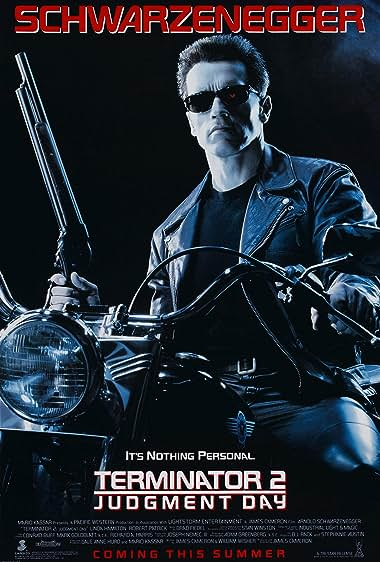


Description: Nearly 10 years have passed since Sarah Connor was targeted for termination by a cyborg from the future. Now her son John the future leader of the resistance is the target for a newer more deadly terminator. Once again the resistance has managed to send a protector back to attempt to save John and his mother Sarah.

Cast: Arnold Schwarzenegger Linda Hamilton Edward Furlong Robert Patrick Earl Boen
Director: James Cameron
Genres: Action Thriller Science Fiction
Year: 1991

Score = 0.96350753


In [31]:
acs_movies_with_posters(movies_list)

In [32]:
get_all_movies_trailers(movies_list)

Terminator 2: Judgment Day (1991)

 https://www.youtube.com/watch?v=CRRlbK5w8AE


YouTube video comments for Terminator 2: Judgment Day (1991) :

Comment 01: 30 years of Terminator 2: Judgment Day,  still the greatest action film ever made!
Comment 02: This masterpiece is over 30 years old and still holds up in the special fx department Today.  
Comment 03: Im 39, i turn 40 on Saturday and i can STILL remember my grandpa taking my 9 year old self to see this movie in the theater in 1991 and it blew my mind. To this day this is my favorite movie of all time and it will never be topped. What a classic.
Comment 04: One of the greatest movies of all time. A true cinematic marvel. An absolute masterpiece that's stood the test of time. It's entertained us for decades, and will continue to do so for decades to come.
Comment 05: Back when the movie was better than the trailer.
Comment 06: One of the best action movies of all time!
Comment 07: It would've been a hell of a plot twist if they never revealed that he was actually good in the trailers. Imagine watching the film a

YouTube video comments for The Dark Knight (2008) :

Comment 01: 10 years later, still one of the greatest movies ever made.
Comment 02: Still the greatest superhero movie ever made hands down. Goosebumps even after 14 years.
Comment 03: As a true Marvel fan, this is a masterpiece.
Comment 04: It’s difficult to describe the experience of having seen this opening day in a crowded theater. On screen, this movie was alive. It was like it was actually happening. To this day, the greatest theatrical experience I’ve ever had.
Comment 05: Just finished watching the trilogy for the first time. Saw some scenes as a child, but now I finally realise why it has 9.0 on IMDb. From the cast, scenes, music, story and the message it sends I can't say anything else than that it's a MASTERPIECE.
Comment 06: I’ve never left a movie more excited and happy in my life. This movie was an absolute masterpiece
Comment 07: I am truly jealous of those who saw this in theaters.
Comment 08: It’s hard to adequately 

YouTube video comments for L.A. Confidential (1997) :

Comment 01: This is one of the best movies of all time especially in the crime/drama genre. A+ acting by all involved. Timeless classic
Comment 02: Timeless film that I never get tired of watching. Guy Pierce stole the show. Great acting and spectacular story line. A must watch if your into crime thriller. This movie will become a classic film
Comment 03: Still to this day when asked my favorite film of all time, I say LA Confidential. It has everything you could want in a masterpiece. Including sharp looking guys in fitted suits in an era I love 
Comment 04: Glad I’m not the only one who thinks this trailer is awful, it massively undersells the movie.
Comment 05: The actors are excellent. The film is dynamic, with a great plot and meaning.
Comment 06: This movie is flippin’ awesome, one of my favourites all three dominated their roles
Comment 07: Looks like an awesome movie with excellent choice of actors
Comment 08: Such a great 

YouTube video comments for Die Hard (1988) :

Comment 01: As they say, "Yippee ki yay" Such an iconic film! Every aspect of it was amazing, the storyline, the characters, the soundtrack, and the action were all great and literally legendary! Decided to watch it on Christmas day again, and what a film. Hard to find anything similar these days, what a time. Such an amazing cast as well, especially with Willis in his prime. So sad to see him in the condition he is now, and hearing about the passing of  Gilyard, few months back. But we can all agree on this movie and their talent will always have an everlasting legacy.  If you're looking for a perfect action-packed, film; This is it! Unforgettable.
Comment 02: Die Hard is a Christmas movie and nobody's gonna convince me differently.
Comment 03: Best Christmas movie ever!
Comment 04: Seven robbers. Two cops. One Gina. The odds are against Jake Peralta... That's just the way he likes it.
Comment 05: One of the greatest action as well as Chri

YouTube video comments for Blade Runner (1982) :

Comment 01: This is an amazing masterpiece of a movie. It’s stunning and the mix of the soundtrack with the cinematography and amazing casting works perfectly. Anyone who sees this should NOT be fooled by the trailer. This is an incredibly sophisticated movie, and it’s a stunning movie. I love this so much
Comment 02: Masterpiece of Ridley Scott's genious. Without doubt Blade Runner is the movie which ages best among all the sci-fi movies. 10 years, 20 years, 30 years ... you can watch it as a timeless classic any time. That is true magic.
Comment 03: Back in 1982, when this movie came out, 2019 must have seemed so far into the future. Now, as I type this, 2019 is a part of history.
Comment 04: 2020 expectations: How flying cars work
Comment 05: I must admit I was not a fan of this movie when it first came out, but over the years it has grown on me. 
Comment 06: This film.... let me tell you about this film.
Comment 07: BLADE RUNNER was

YouTube video comments for The Godfather (1972) :

Comment 01: In an age where the word "masterpiece" is casually thrown left and right, 
Comment 02: I was lucky enough to see this masterpiece in theaters last night, and it was absolutely terrific. Even though I’ve seen it a thousand times before, seeing it on the big screen was incredible.
Comment 03: My dad watched it in 1972 in theatres and I was lucky enough to take him to the theatres 50 years later and watch this once in a lifetime masterpiece. He enjoyed it even better than what he did then 
Comment 04: This was one of the most incredible theater experiences I've ever had in my life, thank you Paramount and Francis Ford Coppola for this amazing treat!
Comment 05: No cringe fighting, suspense plan attack, no standard action, one of the perfect film ever made in the world.
Comment 06: Even this trailer can give goosebumps. This movie had shown the new way to world cinema. In Last 50 years many films had references from this movie.

YouTube video comments for Heat (1995) :

Comment 01: Guys if u need a movie request please let me know I will do my best to download them
Comment 02: How you managed to get this entire 3 hour masterpiece on YouTube in pretty good quality and still have it not taken down yet is absolutely incredible
Comment 03: Truly an epic movie. Two acting legends playing on the different sides of the law but have mutual respect for each other.
Comment 04: One of the greatest movies of the last thirty years. Astonishingly deep storyline, excellent script, top tier acting. What a treasure.
Comment 05: This is by far one of the most tightly executed films. No holes in the storyline, each scene intricately connects to the next, slowly connecting the story. One needs to LISTEN to every line & will understand the web of this superbly written story. This film runs on all cylinders for those who pay attention to all the great details. Michael Mann would never write a loose fitting story, not his style. He’

YouTube video comments for The Silence of the Lambs (1991) :

Comment 01: The Silence Of The Lambs is one of the most greatest psychological horror movies of all time. The story, performance's, music, images, astomphere, tension, and cinematography was so suspenseful, frightening, haunting, mysterious, thrilling, intense, eerie, creepy, and spooky 
Comment 02: Anthony Hopkins, legend, one of the greatest actors of all time
Comment 03: Looks awesome. Can’t wait to see it in theaters.
Comment 04: The Silence of the Lambs is one of the most devoted films from MGM. My favourite suspense/thriller of all time from legendary director Jonathan Demme of devoted dark comedies such as Something Wild and Married to the Mob
Comment 05: What a legend and one of my favorite movies
Comment 06: this movie is the scariest in my opinion. what makes it scary is that this could happen different movies like the shining, the exorcist, and other scary movies i know the stuff in it aren’t real. but in this….it

YouTube video comments for Speed (1994) :

Comment 01: One of the best action movies of the 90s, still holds up.
Comment 02: One of the best action movies of the 90’s. You could just FEEL the heat coming off of this movie. I truly miss this era of film making. When action film directors really had to work hard to sell you their story. Glad to have this film as apart of my young adult years.
Comment 03: Speed, Die Hard with a Vengeance, Bad Boys, Eraser, The Negotiator, Metro,  True Lies, Terminator 2, Crimson Tide, The Rock etc. the greatest action movies of the 1990's hands down! That was a glorious decade, man.
Comment 04: 90s era of Action blockbusters will never ever be replicated. The best decade!!! 
Comment 05: This is still one of my favorite movies, just never gets old. You can really watch this masterpiece over and over again. The tension, the emotions and effects are brilliant. Also each role is played so well. Just a banger of a  movie, even to this day.
Comment 06: One of t

YouTube video comments for Escape from Alcatraz (1979) :

Comment 01: I had no way of expecting the trailer to be like this.  It's as if it's made to be a comedy, in part.
Comment 02: Clint doing what he does best 
Comment 03: This is One of those movies that  plays with your Nerves so Bad, also chilling performance by the Actors, they really feel like prisoners
Comment 04: Probably this is the best prison escape drama movie of all time!
Comment 05: Such a badass movie.
Comment 06: One of his best performances!
Comment 07: One of the best prison movies ever made
Comment 08: I salute Clint and his father Clarence Angling Rodgers along with brother John Angling,and Frank Morris who were the only three man to make it out of Alkatraz alive,Frank lived 2 months,John lived 8 years and Clint's father lived 28 years as owner and propieter of Dominoes pizza.
Comment 09: Moisture corrodes the walls, salt corrodes the metal structures, all full of holes that compromise the security of that infamo

## Test 2

In [33]:
mytopgenres = ", ".join([genres_list[8]])
print(mytopgenres)

mytopactors = ", ".join(
    [actors_list[30], actors_list[40], actors_list[45], actors_list[47]]
)
print(mytopactors)

Western
Val Kilmer, Will Smith, Richard Dreyfuss, Johnny Depp


In [34]:
prompt = f"I want to see a movie. Show me a list of 3 movies. \
My favorite genres are: {mytopgenres} and my favorite actors are: {mytopactors}.\
 I want you to save only the movie title in a numbered list with the release year."

answer = azure_chatgpt_movies(prompt)

Prompt: I want to see a movie. Show me a list of 3 movies. My favorite genres are: Western and my favorite actors are: Val Kilmer, Will Smith, Richard Dreyfuss, Johnny Depp. I want you to save only the movie title in a numbered list with the release year.

Response: Sure! Here are three movies that match your preferences:

1. Tombstone (1993)
2. Wild Wild West (1999)
3. Once Upon a Time in Mexico (2003)

Which one would you like to know more about?

Powered by Azure AI
05-Sep-2023 13:50:14


In [35]:
movies_list = get_list(answer)

Movie 1: Tombstone (1993).
Movie 2: Wild Wild West (1999).
Movie 3: Once Upon a Time in Mexico (2003).



Movie title: Tombstone
Movie ID: tt0108358


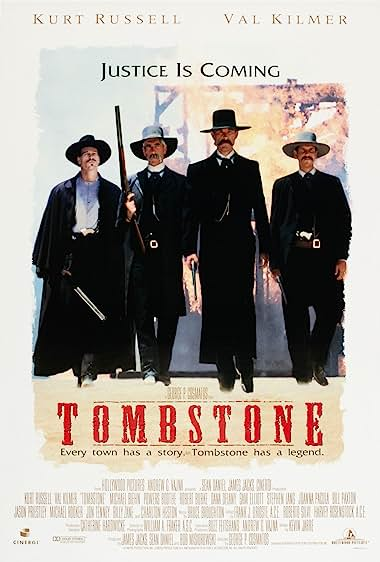


Description: Legendary marshal Wyatt Earp now a weary gunfighter joins his brothers Morgan and Virgil to pursue their collective fortune in the thriving mining town of Tombstone. But Earp is forced to don a badge again and get help from his notorious pal Doc Holliday when a gang of renegade brigands and rustlers begins terrorizing the town.

Cast: Kurt Russell Val Kilmer Sam Elliott Bill Paxton Stephen Lang
Director: George P. Cosmatos
Genres: Action Adventure Drama History Western
Year: 1993

Score = 0.94058454


In [36]:
acs_movies_with_posters(movies_list)

In [37]:
get_all_movies_trailers(movies_list)

Tombstone (1993)

 https://www.youtube.com/watch?v=MICPyrnGYwg


YouTube video comments for Tombstone (1993) :

Comment 01: A room of people that thinks he's just joking around but Johnny and Doc knew. Doc mimicked his entire routine by only seeing it once, a routine Johnny probably practiced many times to get down. What a scene, what a movie
Comment 02: “Not Me, I’m in my prime” greatest movie line ever. Val killed it 
Comment 03: “Look darlin, it’s Johnny Ringoo” kills me everytime
Comment 04: Watching Val play that role never gets old. He really sold his sickness and his final seen actually brought a tear to my eye.
Comment 05: I know everyone creams over Val Kilmer, and rightly so, but the 
Comment 06: Val Kilmer is grossly underrated, The guy could do it all. Comedy, action and drama. He should have had a lot more under his belt.
Comment 07: Oscar winners get forgotten, but Legends never die. Val Kilmer gives one of the greatest performances ever in the film.
Comment 08: No one has ever portrayed an old western character with so much personalit

YouTube video comments for Wild Wild West (1999) :

Comment 01: I don’t care what people say, this film absolutely slaps! More so now.
Comment 02: Saw this movie when I was a kid and it still looks badass. The Series is pretty good as well.
Comment 03: I loved this movie as a kid...and still do as an adult :P
Comment 04: Say what you want about the story, but the movie still looks great after almost 20 years.
Comment 05: I absolutely love this movie and If you think the Movie and this video/song if on fire should check out the VMA live performance they killed it!
Comment 06: this movie is fucking amazing.  i do not understand all the hate.  it's pure popcorn steampunk gold.
Comment 07: Is it weird to admit that despite being more hated Star Wars Episode 1: The Phantom Menace (1999), I actually love this movie?
Comment 08: When you choose this over being the lead actor in the matrix 
Comment 09: devia REFAZER esse filme nas atualidades, ficaria foda
Comment 10: "oh I've got a telegram f

YouTube video comments for Once Upon a Time in Mexico (2003) :

Comment 01: I still remember it. 2003 was the year Johnny Depp starred in the most thrilling, epic, action-packed movie of that year! I mean his fighting, his quotes, they’re all just so awesome in this movie!
Comment 02: Una película que vi antes de ir a Tokio. También es una película que más me quema el corazón y me hace llorar mejor.
Comment 03: oh boy i can't wait for 2003!
Comment 04: I can’t believe Jonny deep was in my favorite city 
Comment 05: The Pistolero instrumental piece right after "I can dig it" is simply awesome, and fits the trailer to a tee. Frankly, one of the best trailers ever made. "Still..."
Comment 06: Picture this… You’re watching a movie, and suddenly there’s a repartee that is SO BAD, it takes you out of the story.
Comment 07: Such an epic movie
Comment 08: This is the only film I ever saw in a drive-in. Very good movie with excellent actors.
Comment 09: Magnífica película de acción
Comment 10: 

## 2. Based on some history
### Test 1

In [38]:
myfavoritemovies = "Jaws, 47 Meters Down, The Shallows"

In [39]:
prompt = f"My favorites movies are: {myfavoritemovies}.\
 Can you suggest me some 3 similar movies made before 2015? \
 I want you to save only the movie title in a numbered list with the release year."

answer = azure_chatgpt_movies(prompt)

Prompt: My favorites movies are: Jaws, 47 Meters Down, The Shallows. Can you suggest me some 3 similar movies made before 2015?  I want you to save only the movie title in a numbered list with the release year.

Response: Sure, here are three similar movies:

1. Open Water (2003)
2. Deep Blue Sea (1999)
3. The Reef (2010)

Powered by Azure AI
05-Sep-2023 13:50:22


In [40]:
movies_list = get_list(answer)

Movie 1: Open Water (2003).
Movie 2: Deep Blue Sea (1999).
Movie 3: The Reef (2010).



Movie title: Open Water
Movie ID: tt0374102


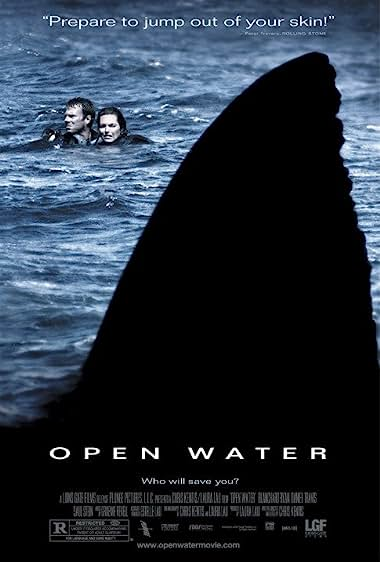


Description: Two divers are left out at sea without a boat. Thereâ€™s nothing but water for miles unless they look at whatâ€™s underneath them...

Cast: Blanchard Ryan Daniel Travis Saul Stein Michael E. Williamson Christina Zenato
Director: Chris Kentis
Genres: Drama Thriller
Year: 2004

Score = 0.960521


In [41]:
acs_movies_with_posters(movies_list)

In [42]:
get_all_movies_trailers(movies_list)

Open Water (2003)

 https://www.youtube.com/watch?v=Z9q1qJi1nMs


YouTube video comments for Open Water (2003) :

Comment 01: I'll never forget the way this ending made me feel. As I walked out the door to the parking lot, the bright sun felt so weird after 90 minutes of literal and figurative darkness. I felt dead inside. Just totally empty.
Comment 02: The fact that the employees who left them behind did not go to jail for their deaths is shocking.
Comment 03: That was disgusting what happened to them .All of this could've  been  avoided.  Bad management from the tour boat operator.
Comment 04: Finally saw this movie, it was phenomenal. One of the scariest movies ever.
Comment 05: this movie had a budget of $100,000 and made $55 million in box office. incredible
Comment 06: To think their families never got to know the truth about what happened to them is utterly heartbreaking.
Comment 07: Watched it today, the ending was so intense and real. I thought they'd be rescued in the end but it's so sad to see them die and it's actually chilling to know t

YouTube video comments for Deep Blue Sea (1999) :

Comment 01: I LOVE this movie, I don't care what anyone says. I remember seeing this in theaters in 1999. Great memories. This classic turns 24 today.
Comment 02: So glad this movie is getting some much deserved love.
Comment 03: This was one the best movies from the ninties and hard to believe it was released in movie theaters 20 years at the end of    July doesn't seem like that long ago.
Comment 04: Was the first R rated movie I got to see in the theater. And loved every moment of it. Still the best shark movie after Jaws.
Comment 05: One of the best movies of my childhood 
Comment 06: Best shark movie ever. Sam Jackson getting abruptly eaten by a shark is still one of the best kills in any movie ever.
Comment 07: Damn, i remember this movie like it was yesterday in the early 2000's. Life was simple back then
Comment 08: This is the best film about sharks, it was my first film about sharks, and it was after this film that I fell in 

YouTube video comments for The Reef (2010) :

Comment 01: This is arguably one of the most realistic shark movies ever made. The films goal was to deliver an authentic lost at sea, shark attack experience and I think it did just that. If you've imposed the Hollywood movie formula onto this movie you've misunderstood what it is and set out to be. It's a glimpse into what a grim situation like that might actually be like. A very realistic and terrifying glimpse IMO.
Comment 02: i absolutely loved this film. with my enormous fear of sharks , its the worst scenario i could ever imagine being in. 
Comment 03: Ive been in a situation like this, and I can tell you people this is as real as a film can get to real life, I was fishing with 2 friends near the Solomon islands 2 years ago when my small fishing boat capsized after being damaged on a reef about a mile out, so we swam, my friend had cut himself bad on reef so a lot of blood was produced, in the last few meters a bull shark followed us

### Test 2

In [43]:
myfavoritemovies = "Manhattan, French connection, Serpico"

In [44]:
prompt = f"My favorites movies are: {myfavoritemovies}.\
 Can you suggest me some 5 similar movies? \
 I want you to save only the movie title in a numbered list with the release year."

answer = azure_chatgpt_movies(prompt)

Prompt: My favorites movies are: Manhattan, French connection, Serpico. Can you suggest me some 5 similar movies?  I want you to save only the movie title in a numbered list with the release year.

Response: Sure, here are some movie recommendations for you based on your favorites:

1. The Godfather (1972)
2. Taxi Driver (1976)
3. Chinatown (1974)
4. Dog Day Afternoon (1975)
5. The French Connection II (1975)

Powered by Azure AI
05-Sep-2023 13:50:31


In [45]:
movies_list = get_list(answer)

Movie 1: The Godfather (1972).
Movie 2: Taxi Driver (1976).
Movie 3: Chinatown (1974).
Movie 4: Dog Day Afternoon (1975).
Movie 5: The French Connection II (1975).



Movie title: The Godfather
Movie ID: tt0068646


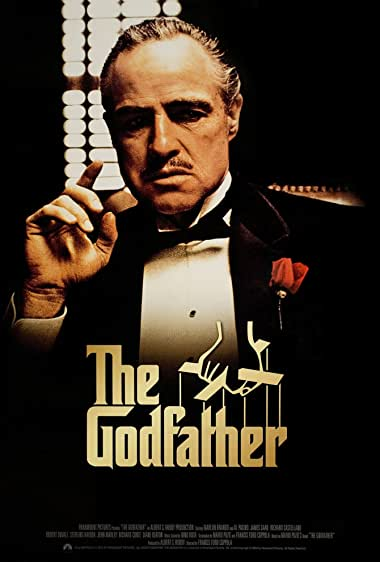


Description: Spanning the years 1945 to 1955 a chronicle of the fictional Italian-American Corleone crime family. When organized crime family patriarch Vito Corleone barely survives an attempt on his life his youngest son Michael steps in to take care of the would-be killers launching a campaign of bloody revenge.

Cast: Marlon Brando Al Pacino James Caan Richard S. Castellano Robert Duvall
Director: Francis Ford Coppola
Genres: Drama Crime
Year: 1972

Score = 0.9393629


In [46]:
acs_movies_with_posters(movies_list)

In [47]:
get_all_movies_trailers(movies_list)

The Godfather (1972)

 https://www.youtube.com/watch?v=UaVTIH8mujA


YouTube video comments for The Godfather (1972) :

Comment 01: In an age where the word "masterpiece" is casually thrown left and right, 
Comment 02: I was lucky enough to see this masterpiece in theaters last night, and it was absolutely terrific. Even though I’ve seen it a thousand times before, seeing it on the big screen was incredible.
Comment 03: My dad watched it in 1972 in theatres and I was lucky enough to take him to the theatres 50 years later and watch this once in a lifetime masterpiece. He enjoyed it even better than what he did then 
Comment 04: This was one of the most incredible theater experiences I've ever had in my life, thank you Paramount and Francis Ford Coppola for this amazing treat!
Comment 05: No cringe fighting, suspense plan attack, no standard action, one of the perfect film ever made in the world.
Comment 06: Even this trailer can give goosebumps. This movie had shown the new way to world cinema. In Last 50 years many films had references from this movie.

YouTube video comments for Taxi Driver (1976) :

Comment 01: This is going to be a great movie, can't wait for 1976
Comment 02: can’t wait for this to come out
Comment 03: A film that will still be relevant for decades to come.
Comment 04: An absolute masterpiece. Watching De Niro’s portrayal of Bickel’s descent into madness fuelled by a hatred of a society from which he feels disconnected, should serve as a warning to those in positions of power today that actively seek to isolate, denigrate and segregate certain classes of people by their increasingly insane ideology of holding the generation of today responsible for the sins of their ancestors.
Comment 05: One of the greatest movies ever made. De Niro and Martin are the greatest combination in the history of film.
Comment 06: Timeless masterpiece of cinema.
Comment 07: One of my favorite neo-noir films. I especially like the scene where Travis says:
Comment 08: Despite having watched the movie, the trailer still gives me chills.
Com

YouTube video comments for Chinatown (1974) :

Comment 01: A MASTERPIECE of a film. From the costumes, the hair and makeup. Everything about this film was done to perfection. The actors are at their prime  and Roman Polanski's directing is masterful. One of Hollywood's best films. Personally, I think it's the BEST film of L.A. in the 30's.
Comment 02: In 1974 I was ten years old. I first saw Chinatown on TV in 1978. A brilliant story about water in an unstable environment. A timeless movie that never goes out of date!!
Comment 03: It's weird to think that making this movie set in 1937 then would be the equivalent of making a movie set in 1984 this year.
Comment 04: Each single shot is to enjoy endless without being bored.Just incredible. Polanski is the utmost   badass in cinema history.
Comment 05: One of the best films of the seventies which is saying something.  Three excellent performances, Nicholson, Dunaway and Huston.
Comment 06: If there's ever a film where I love every second,

YouTube video comments for Dog Day Afternoon (1975) :

Comment 01: What a power of improvisation, a small circle of such quality actors as AL Pacino. He won only one Oscar, but that Oscar is a ridiculous benchmark for such performances, such performances are beyond the limits of art. Long live my hero of youth, one of the best actors of all time, who changed the film world forever, and whose roles set the standards of modern acting!
Comment 02: How does al Pacino manage to look like a whole different person in each movie
Comment 03: I so loved Pacino teasing and shouting outside the bank at everyone and the crowd loved it.
Comment 04: Al Pacino has eyes, beautiful eyes, most beautiful eyes a mortal can have
Comment 05: A dynamite movie, not a dull moment and the plot twists. In my Top 50 of favorite films
Comment 06: I was trying to find something to watch on TV when I was 12 and for some reason I stopped at the channel playing this. Al Pacino's acting hooked me in and I had no idea wh

YouTube video comments for The French Connection II (1975) :

Comment 01: Along with the Godfather Part II one of the best sequels ever made. Controversially I actually prefer this to the first French connection.
Comment 02: My early teenage years crush
Comment 03: Why is Roy Scheider not in this one?
Comment 04: A fine sequel.  Inferior to the original, but who cares?  It’s a fine film in and of itself.  Kind of like Godfather III.




## 3. Post Processing

In [48]:
acs_index_status(index_name)

Azure Cognitive Search Index: moviereview 

{
     "@odata.context": "https://azurecogsearcheastussr.search.windows.net/$metadata#indexes/$entity",
     "@odata.etag": "\"0x8DBAE03DD8B3409\"",
     "name": "moviereview",
     "defaultScoringProfile": null,
     "fields": [
          {
               "name": "imdb_id",
               "type": "Edm.String",
               "searchable": false,
               "filterable": true,
               "retrievable": true,
               "sortable": true,
               "facetable": true,
               "key": true,
               "indexAnalyzer": null,
               "searchAnalyzer": null,
               "analyzer": null,
               "normalizer": null,
               "synonymMaps": []
          },
          {
               "name": "title",
               "type": "Edm.String",
               "searchable": true,
               "filterable": true,
               "retrievable": true,
               "sortable": false,
               "facetable": f

In [49]:
document_count, storage_size = acs_index_stats(index_name)

Azure Cognitive Search index status for: moviereview 

{
  "@odata.context": "https://azurecogsearcheastussr.search.windows.net/$metadata#Microsoft.Azure.Search.V2021_04_30_Preview.IndexStatistics",
  "documentCount": 10784,
  "storageSize": 564411366
}


### We can delete the index if needed

In [50]:
# acs_delete_index(index_name)

> Go to the next notebook